# import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import psycopg2
import rasterio as rs
from rasterio.plot import show
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import scipy.spatial
import libpysal as ps
from pointpats import PointPattern
import mplleaflet

In [2]:
# to make sure autocomplete works
%config Completer.use_jedi = False

import warnings
warnings.filterwarnings("ignore")

In [3]:
os.chdir('G:\\MLRP\\SGS\\DataMan\\Mahmoodi\\Projects\\2020_Potential_Mapping\\Original_Data\\csv_files')

# import data

* Shapefiles are stored in a Postgresql database, and can be imported into Python by creating a connection to the database. Dataset used in this library are spatial data including points, polylines, polygons, and raster data. Once the data are imported, they are checked to make sure thay have a common coordinate reference system (CRS). 

## area of interest
* Imports a polygon showing the area of interest. A shapefile is also imported to show the location of large lakes which were not accessible to collect some data. The aoi polygon is filled with points 500 m apart to form a uniform grid in the area. This grid is used to resample the data to store all information in a GeoDataFrame.

In [4]:
# creates a new database connection
con=psycopg2.connect(host="localhost",database="MPM_RZ", user="postgres", password="1111")

aoi=gpd.GeoDataFrame.from_postgis('SELECT * FROM aoi_rz',con, geom_col='geom')
lake=gpd.GeoDataFrame.from_postgis('SELECT geom FROM lakes_hole', con)

In [5]:
# masks lakes
aoi_wo_lake=gpd.overlay(aoi, lake, how='difference')
# removes small polygon
aoi_wo_lake= aoi_wo_lake.explode().reset_index(drop=True).loc[[0]]

In [6]:
ax = aoi.to_crs({'init': 'epsg:4326'}).boundary.plot(figsize=(6,10))
mplleaflet.display(fig=ax.figure, tiles='esri_aerial')

In [7]:
# creates point grids 
cell_size=500
# bounds return minx, maxx, miny, maxy
x= np.arange(aoi.bounds.loc[0, 'minx'], aoi.bounds.loc[0,'maxx'], cell_size)
y= np.arange(aoi.bounds.loc[0,'miny'], aoi.bounds.loc[0,'maxy'], cell_size)

# returns x and y coordinates for all points  
xx, yy = np.meshgrid(x, y)
xx= xx.ravel()
yy=yy.ravel()
# creates a GeoDataFrame
df= gpd.GeoDataFrame(geometry=gpd.points_from_xy(xx,yy), crs=aoi.crs)

In [8]:
# indicates a point is inside or outside the aoi; doesn't work without unary_union
df['aoi']=df.geometry.within(aoi.unary_union)
df['aoi_wo_lake']=df.geometry.within(aoi_wo_lake.unary_union)

In [9]:
df.head(2)

,geometry,aoi,aoi_wo_lake
0,POINT (423863.679 6043207.265),False,False
1,POINT (424363.679 6043207.265),False,False


In [10]:
# create mask files to be used for plotting
mask_aoi=np.array((~df['aoi']).astype(int)).reshape(859,560)
mask_aoi_wo_lake=np.array((~df['aoi_wo_lake']).astype(int)).reshape(859,560)

## nts
* NTS is an Index Map showing the National Topographic System. This map will be used later for random data selection. There were some NTS number with small areas which were merged with neighbouring NTS. 

In [11]:
nts=gpd.GeoDataFrame.from_postgis('SELECT geom, nts FROM nts_250k',con, geom_col='geom')
nts=nts.to_crs({'init': 'epsg:2151'})

# clips nts to aoi
nts=gpd.overlay(nts, aoi)[['geometry','nts']]

In [12]:
# merge small nts' with larger ones
nts['nts'].replace({'064L':'064E', '073O':'073P', '073I':'063L','063K':'063L', '063N':'063M', '074H':'064E'}, inplace=True)
# merge newly renamed nts with each other
nts=nts.dissolve(by='nts', as_index=False)#.plot(column='nts', edgecolor='grey')

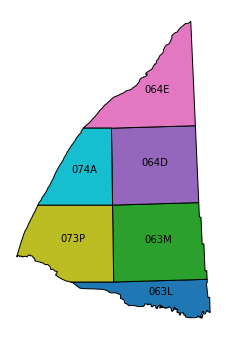

In [13]:
ax=nts.plot(column='nts', figsize=(6,6), edgecolor='black')
ann=nts.apply(lambda x: ax.annotate(s=x.nts, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)
ax.set_axis_off()

In [14]:
# adds nts information to df
df=gpd.sjoin(df, nts, how='left').drop('index_right', axis=1)

In [15]:
df.loc[df['aoi']].head(2)

,geometry,aoi,aoi_wo_lake,nts
1061,POINT (674363.679 6043707.265),True,True,063L
1062,POINT (674863.679 6043707.265),True,True,063L


## faults
* Major faults (polyline) and shear zones (1M scale) are imported into a GeoDataFrame (faults). This information is added to df in a form of distance of each point to the features. 

In [16]:
faults=gpd.GeoDataFrame.from_postgis('SELECT geom FROM faults_1m',con, geom_col='geom')

In [17]:
# computes distance from each point to the closest fault
df.loc[df['aoi'], 'dist_to_faults']= df.loc[df['aoi']].geometry.distance(faults.unary_union)

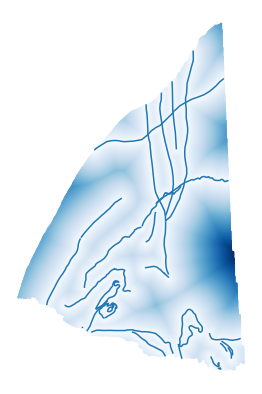

In [18]:
fig, axes= plt.subplots(1,1,figsize=(7,7))
df.loc[df['aoi']].plot(column='dist_to_faults', ax=axes, markersize=0.5, cmap='Blues')
faults.plot(ax=axes)
axes.set_axis_off()

## mineral deposit index
* Locations of mineral indices were imported into a gdf named as mineral_index. The 'com_group' field was used to filter the data and select indices of gold and base metal. A buffer with 300 m radius was created around each point. Using spatial join, all points of the uniform grid within the buffer were represented as target (Gold or Base Metal). 

In [19]:
mineral_index=gpd.GeoDataFrame.from_postgis('SELECT geom, com_group,type FROM mineral_deposit_index_rz', 
                                            con, geom_col='geom')

In [20]:
# selects SMDI of Base Metal and Gold
mineral_index=mineral_index[(mineral_index['com_group']=='Base Metal') | (mineral_index['com_group']=='Gold')]

(431954.1580611161, 715882.8519388837, 6024375.23049651, 6465640.82950349)

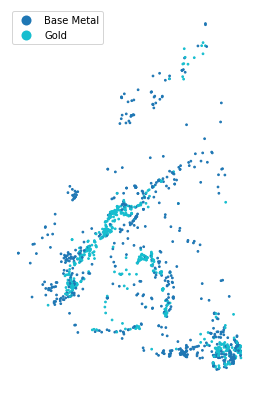

In [21]:
mineral_index.plot(column='com_group', legend=True, markersize=3, figsize=(7,7))
plt.axis(False)

In [22]:
# creates buffer around indices
mineral_index['buffer']=mineral_index.buffer(300)
mineral_index.set_geometry(col='buffer', inplace=True)
mineral_index.drop('geom', axis=1, inplace=True)# otherwise it gives an error with two geometry columns

In [23]:
# merges df and smdi to add mineral indices information to df; then creates two columns for Base Metal and Gold
df=gpd.sjoin(df,mineral_index,how='left', op='within').drop('index_right', axis=1)
df= df[~df.index.duplicated()]
df=pd.get_dummies(df,columns=['com_group'], prefix='', prefix_sep='')

In [24]:
df.loc[df['aoi']].head(2)

,geometry,aoi,aoi_wo_lake,nts,dist_to_faults,type,Base Metal,Gold
1061,POINT (674363.679 6043707.265),True,True,063L,158.872032,NaN,0,0
1062,POINT (674863.679 6043707.265),True,True,063L,299.379401,NaN,0,0


In [25]:
# number of targets in the area
print(df['Gold'].sum())
print(df['Base Metal'].sum())

619
724


## bedrock
* Bedrock geology map (1:250k scale)  was imported. There were some modifications (combining similar rocks with different codes) implemented on the shapefile before importing it here to reduce the number of rock codes. Similar to other data, the uniform grid is used to resample the bedrock polygon using a spatial join.

In [26]:
bedrock=gpd.GeoDataFrame.from_postgis('SELECT * FROM dissolved_bedrock_codes', con, geom_col='geom')
bedrock=bedrock.to_crs({'init': 'epsg:2151'})

In [27]:
bedrock=bedrock[['geom','rock_code']]
# creates a 0 m buffer to fix errornous polygon and avoid disruption during spatial joins
bedrock= bedrock.set_geometry(col=bedrock.buffer(0))

In [28]:
bedrock.head(2)

,geom,rock_code
0,"MULTIPOLYGON (((702620.239 6065937.614, 702683...",Lva
1,"MULTIPOLYGON (((557026.694 6092510.908, 558078...",Gvd


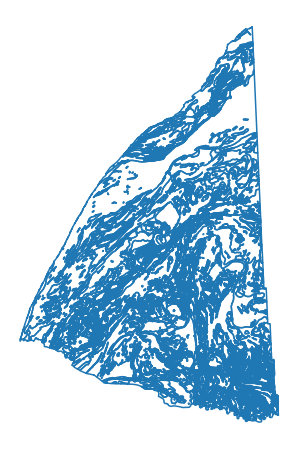

In [29]:
bedrock.boundary.plot(figsize=(8,8))
plt.axis(False); plt.show()

In [30]:
# adds bedrock info to df using spatial join
df=gpd.sjoin(df, bedrock, how='left').drop('index_right', axis=1)

In [31]:
df.loc[df['aoi']].head(2)

,geometry,aoi,aoi_wo_lake,nts,dist_to_faults,type,Base Metal,Gold,rock_code
1061,POINT (674363.679 6043707.265),True,True,063L,158.872032,NaN,0,0,NaN
1062,POINT (674863.679 6043707.265),True,True,063L,299.379401,NaN,0,0,NaN


## metamorphic facies
Metamorphic facies information are stored in a polygon, which are added to df through spatial join. 

In [32]:
m_facies=gpd.GeoDataFrame.from_postgis('SELECT dominant_f as meta_f, st_collectionextract AS geom  FROM metamorphic_facies_rz', 
                                       con, geom_col='geom')
m_facies=m_facies.to_crs({'init': 'epsg:2151'})

In [33]:
# removes empty entries
m_facies=m_facies[~m_facies['geom'].is_empty]

In [34]:
m_facies=m_facies.dissolve('meta_f', as_index=False)

In [35]:
m_facies.head(2)

,meta_f,geom
0,Amphibolite,"POLYGON ((679971.959 6372017.882, 677957.538 6..."
1,Granulite,"POLYGON ((589063.345 6222500.408, 589089.358 6..."


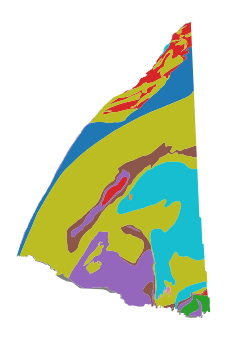

In [36]:
ax=m_facies.plot(column='meta_f', figsize=(6,6))
ax.set_axis_off()

In [37]:
df=gpd.sjoin(df, m_facies, how='left').drop('index_right', axis=1)

In [38]:
df.loc[df['aoi']].head(2)

,geometry,aoi,aoi_wo_lake,nts,dist_to_faults,type,Base Metal,Gold,rock_code,meta_f
1061,POINT (674363.679 6043707.265),True,True,063L,158.872032,NaN,0,0,NaN,Unmetamorphosed Phanerozoic
1062,POINT (674863.679 6043707.265),True,True,063L,299.379401,NaN,0,0,NaN,Unmetamorphosed Phanerozoic


## geophysical data
* Geophysical data (gravity, residual magnetic, and analytic signal of the magnetic data) grids were stored as tiff files. Raster files can be imported using rasterio library. Note that the tiff files should contain only one band (tiff files exported from ArcMap), because RGB files don't store actual values of the data. 

In [39]:
rmi_raster= rs.open('rmi_rz.tif')
rmi_as_raster=rs.open('rz_as.tif')
grav_raster= rs.open('grav_rz.tif')

In [40]:
# a function to resample geophysical raster using the uniform grid of points
def sample_raster(r, gdf):
    # returns the values of the raster in a 2D array
    r_arr= r.read(1)
    r_arr[r_arr==-99999]=np.nan
    # empty 2d array to store xs and ys for each pixel 
    r_xx= np.zeros(r_arr.shape)
    r_yy= np.zeros(r_arr.shape)
    # r.xy returns a tuple of coordinates for each pixel
    for idx, v in np.ndenumerate(r_xx):
        r_xx[idx],r_yy[idx] =r.xy(row= idx[0],col= idx[1])
    # interpolates the data to the location of df[aoi] points
    sampled_r = griddata((r_xx.ravel(), r_yy.ravel()), r_arr.ravel(),
                                   (gdf[gdf['aoi']].geometry.x,gdf[gdf['aoi']].geometry.y),method='linear')
    return sampled_r

In [41]:
# adds geophysical data to df
df.loc[df['aoi'],'rmi']= sample_raster(rmi_raster, df)
df.loc[df['aoi'],'grav']= sample_raster(grav_raster, df)
df.loc[df['aoi'],'rmi_as']= sample_raster(rmi_as_raster, df)

In [42]:
df.loc[df['aoi']].head(2)

,geometry,aoi,aoi_wo_lake,nts,dist_to_faults,type,Base Metal,Gold,rock_code,meta_f,rmi,grav,rmi_as
1061,POINT (674363.679 6043707.265),True,True,063L,158.872032,NaN,0,0,NaN,Unmetamorphosed Phanerozoic,NaN,NaN,0.198047
1062,POINT (674863.679 6043707.265),True,True,063L,299.379401,NaN,0,0,NaN,Unmetamorphosed Phanerozoic,NaN,-52.437813,0.176018


## lake sediment data
* The shapefile (point) contains the location of lake sediment analyses in the area. Only 12 elements had enough data to be considered in this project. 

In [43]:
geochem=gpd.GeoDataFrame.from_postgis('SELECT * FROM gsc_lake_sediment_analyses_rz',con, geom_col='geom')

geochem=geochem[['geom', 'as_',  'au','co','cu', 'fe', 'hg',
       'mn', 'mo', 'ni', 'pb', 'u', 'zn']]

In [44]:
geochem.head(2)

,geom,as_,au,co,cu,fe,hg,mn,mo,ni,pb,u,zn
0,POINT (427416.540 6144102.469),-1,0,7,16,1.00,65,215,2,19,-2,1.9,55
1,POINT (429670.690 6138023.033),3,1,7,22,2.45,42,380,2,20,2,1.5,60


In [45]:
# negative values are considered as missing values  
for col in geochem.drop('geom', axis=1).columns:
    geochem.loc[(geochem[col]<=0),[col]]=np.nan

In [46]:
# % of missing values for each element
((geochem.drop('geom',axis=1).isnull().sum()/len(geochem))*100).sort_values()[-6:]

co      0.490824
hg      1.515152
mo     19.376867
as_    27.379428
pb     42.445583
au     48.868971
dtype: float64

###  filling au missing values in the north
* 49 % of au values is missing, and the majority of them are located in the North (orange dots in the map below). There was no report explaining why au values were not reported for samples above a specific latitude. Given the importance of including au values in this work, it was critical to replace the missing values rather than removing the data. With all missing data located in the north, filling the missing data with a value (mean, median, rtc.) was not an option. Therefore, I decided to predict au values based on other elements. A support vector regressor was used to make the prediction. 

In [47]:
# data within zone 'N' have missing au values
geochem.loc[geochem.geometry.y>6316649, 'zone']='N'
geochem.loc[geochem.geometry.y<=6316649, 'zone']='S'

# generates training data from zone S
south=geochem[geochem['zone']=='S'].drop(['as_', 'pb', 'mo','geom','zone'], axis=1).dropna()
south_X=south.drop('au', axis=1)
south_y=south['au']
# generates df for prediction data from zone S
north_X= geochem[geochem['zone']=='N'].drop(['as_', 'pb', 'mo','au','geom','zone'], axis=1).dropna()

In [48]:
# scales the data, 
scaler=StandardScaler()
scaler.fit(south_X)

south_X_sc=scaler.transform(south_X)
north_X_sc=scaler.transform(north_X)

# log transform of the target (au)
south_y=np.log(south_y.values)

In [49]:
X_train, X_test, y_train, y_test=train_test_split(south_X_sc, south_y, test_size=0.3)
lr=SVR()
lr.fit(X_train, y_train)
# adds predicted values to geochem
geochem.loc[north_X.index, 'au']= np.exp(lr.predict(north_X_sc))

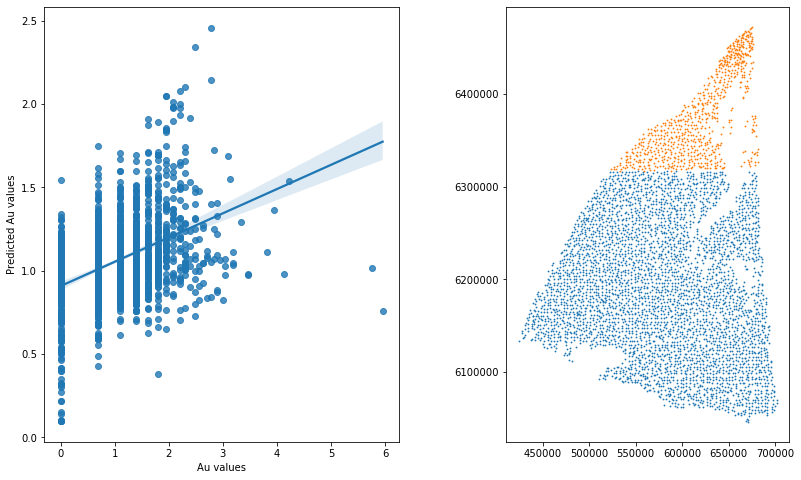

In [50]:
# the crossplot clearly shows that the prediction isn't the best, but it provides more accurate data compared to using a 
# constant value to replace the data. 
fig, ax= plt.subplots(1,2, figsize=(14,8))
sns.regplot(y_train, lr.predict(X_train), ax=ax[0])
ax[0].set_xlabel('Au values'); ax[0].set_ylabel('Predicted Au values')
geochem[geochem['zone']=='S'].plot(ax=ax[1], markersize=0.7)
geochem[geochem['zone']=='N'].plot(ax=ax[1],markersize=0.7)

In [51]:
geochem=geochem.drop('zone', axis=1)

### fillna for all elements by average of neighbouring samples
* With missing au values in the North being replaced by a regression model, it's time to replace missing values for the other elements. Rather than using a constant value, the missing data were replaced by local average values. For each point with missing value, the average value was calculated using its 12 neighbours.

In [52]:
elements= geochem.drop('geom', axis=1).columns

In [53]:
# https://pysal.org/notebooks/explore/pointpats/distance_statistics.html
pp = PointPattern([(p.x, p.y) for p in geochem.geometry])

# gets indices of 12 neighbours for each point. first array is indices, second is distance.
nearest_points=pp.knn(12)[0]

In [54]:
# iterates through geochem, for each row checks if any column is null, replaces it with average of 12 neighbors
# run twice, or put a while geochem.isnull().sum().sum()>0:
while geochem.isnull().sum().sum()>0:
    for index, row in geochem.iterrows():
        for col in elements:
            if pd.isnull(row[col]):
                geochem.loc[index, col]= geochem.loc[nearest_points[index], col].median()

In [55]:
sum(geochem.isnull().sum())

0

### Correlation matrix and Principal Component Analysis
* A correlation matrix was created to show relationship between elements. Based on the graph, Cu, Ni, Co, and Zn are correlated. Fe and Mn are correlated. Au doesn't show any correlation with other elements (another reason of poor performance of the SVR). 


* Principal component analysis was implemented to reduce the number of variables and linearity between variables. The first three components could explain 65% of data variation.  Eigenvectors of components indicate elements represented by first 6 components: PC1: Cu, Co, Mn, Ni; PC2: U; PC3: Fe and Mn; PC4: As, Au, and Hg; PC6: Au.


* The goal of using PCA was to reduce the number of features (elements) to a couple components. However, relatively low eigenvectors of PCs (0.4 ~0.5) indicates that a single component cannot explain variation of elements. So, it's better to use the elements themselves. 

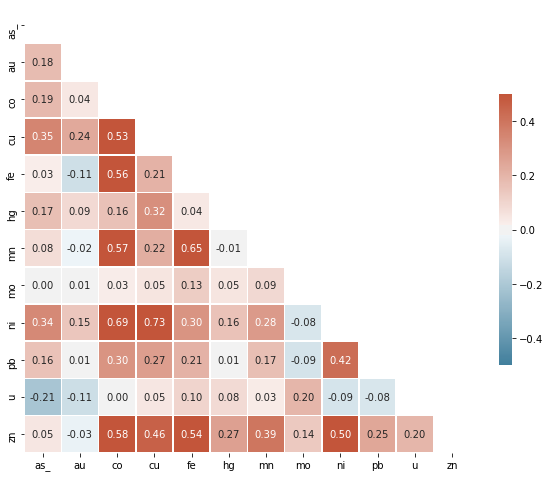

In [56]:
corr_elements=geochem[elements].corr('spearman')

mask_cr = np.triu(np.ones_like(corr_elements, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_elements, mask=mask_cr, cmap=cmap, vmax=.5, vmin=-0.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')

In [57]:
# variables with skewness greater than 0.5 were normalized using log transform.
# normalization is important in PCA since it is a variance maximizing exercise
for col in elements:
    if abs(geochem[col].skew()) > 0.5:
        geochem[col]= geochem[col].apply(np.log) 
        
pca = PCA(n_components=len(elements))
principalComponents = pca.fit_transform(geochem[elements])
principalDf = pd.DataFrame(data = principalComponents)

pca.explained_variance_ratio_*100

array([27.53991104, 24.28339255, 13.48516781,  7.11708091,  6.44089435,
        6.17341292,  3.88552429,  3.29901442,  2.65378789,  2.2146861 ,
        1.48812297,  1.41900475])

Text(0, 0.5, 'Explained variance ratio')

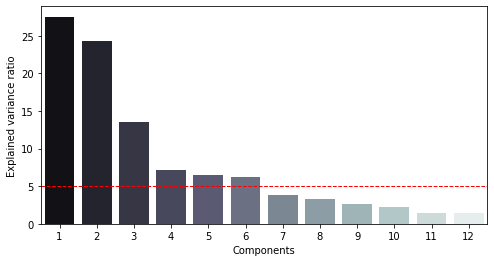

In [58]:
plt.figure(figsize=(8,4))
sns.barplot(x=[i for i in range(1,13)], y=pca.explained_variance_ratio_*100, palette='bone')
plt.axhline(5,ls='--',c='red', lw=1)
plt.xlabel('Components'); plt.ylabel('Explained variance ratio')

In [59]:
pd.DataFrame(pca.components_, columns=elements, index=range(1,13))

,as_,au,co,cu,fe,hg,mn,mo,ni,pb,u,zn
1,0.236008,0.071812,0.400439,0.410121,0.323685,0.153887,0.421398,0.022522,0.470836,0.167811,-0.009168,0.232649
2,-0.197909,-0.078461,0.015360,0.007233,0.131011,0.048819,0.049301,0.117095,-0.079066,-0.042559,0.949153,0.098711
3,-0.307979,-0.215372,0.083279,-0.345035,0.412954,-0.304271,0.585924,0.092697,-0.278644,-0.062820,-0.190196,0.002000
4,0.640122,0.308156,-0.149489,-0.137307,0.128436,0.324047,0.227045,0.225369,-0.415764,-0.224740,0.050543,-0.065712
5,0.309284,0.370998,-0.026923,-0.008396,-0.114142,-0.809196,0.097227,-0.039685,0.133011,0.083671,0.185139,-0.167583
6,-0.536010,0.801710,0.014951,0.124065,-0.018512,0.117889,0.079658,0.073512,-0.057579,-0.126321,-0.079339,0.052738
7,0.012475,0.181077,-0.085622,-0.261454,0.226615,0.103604,-0.143036,0.007458,-0.139470,0.886466,0.012986,0.057627
8,0.030890,-0.003349,-0.056768,0.190771,0.550401,-0.256072,-0.532389,0.448647,-0.036859,-0.169548,-0.121302,0.247716
9,-0.075556,-0.162699,-0.184049,0.302539,-0.451880,-0.056093,0.246974,0.706672,-0.085167,0.245845,-0.064851,0.052856
10,-0.039458,-0.075608,-0.586982,0.589374,0.217031,-0.052304,0.156588,-0.400204,-0.241097,0.077553,-0.007339,-0.045821


In [60]:
# adds two new features to df for components that describe variation of indicator elements of Gold and Base Metal
geochem['PC_BM']=principalDf[0]
geochem['PC_Gold']= principalDf[5]+principalDf[3]

### grid lake sediment data
* Lake sediment data were interpolated to get values for each element at uniform grid points. More information about the gridding can be found here: https://earthscience.stackexchange.com/questions/12057/how-to-interpolate-scattered-data-to-a-regular-grid-in-python


* Note that the interpolation is limited to the aoi without lakes because there are no lake sediment data available over the lakes.  

In [61]:
xg= geochem.geom.x.values
yg= geochem.geom.y.values

xw= df.geometry.x.values 
yw= df.geometry.y.values

for col in geochem.drop('geom', axis=1).columns:
    zg= geochem[col].values
    df[col] = griddata((xg, yg), zg, (xw,yw), method='linear')

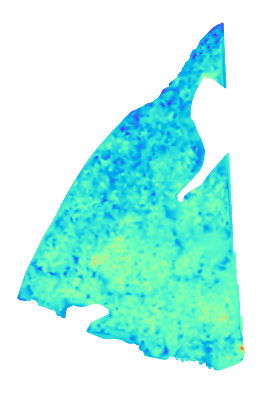

In [62]:
fig, axes= plt.subplots(1,1,figsize=(7,7))
df.loc[df['aoi_wo_lake']].plot(column='cu', ax=axes, markersize=0.5, cmap='rainbow')
axes.set_axis_off()

# missing values
* There are a few null values for rock_code and metamorphic_facies at the aoi boundary due to having narrow sleeves for aoi polygon. These points were excluded from aoi.


* There are a few null values for numeric values mainly at the aoi border caused during resampling and interpolation process (scipy.interpolate.griddata returns null for points outside the points convex hull). They were simply filled by interpolating the data. Note that the GeoDataFrame was initially converted to a DataFrame to be able to use the interpolate method for filling null values because gpd.interpolate is executed for geometries (gpd.interpolate vs. pd.interpolate).

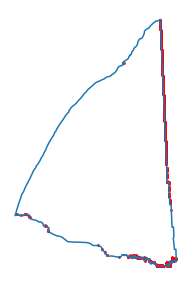

In [63]:
# plots points with missing bedrock information
fig, ax=plt.subplots(1,1, figsize=(5,5))
df[(df['aoi']) & (df['rock_code'].isnull())]['geometry'].plot(figsize=(10,10), c='red',ax=ax, markersize=3)
aoi.boundary.plot(ax=ax)
ax.set_axis_off()

In [64]:
# ignore points inside aoi without bedrock or metamorphic information. mainly located at aoi border
df.loc[(df['aoi']) & (df['rock_code'].isnull()),'aoi']=False
df.loc[(df['aoi']) & (df['meta_f'].isnull()),'aoi']=False

# makes sure that if there is a point outside aoi, it must be outside the aoi_wo_lake.
df.loc[(df['aoi_wo_lake']) & (~df['aoi']), 'aoi_wo_lake']=False

In [65]:
# a list of variables that might be used during data selection or modeling
feat_list= ['rmi', 'rmi_as', 'grav', 'as_', 'au', 'co',
       'cu', 'fe', 'hg', 'mn', 'mo', 'ni', 'pb', 'u', 'zn', 'PC_BM', 'PC_Gold']

In [66]:
# fillna using interpolation
while df.loc[df['aoi'],feat_list].isnull().sum().sum()>0:
    df.loc[df['aoi'],feat_list]= pd.DataFrame(df.loc[df['aoi'],feat_list]).interpolate(limit=90, limit_direction='both')

In [67]:
sum(df.loc[df['aoi']].drop('type', axis=1).isnull().sum())

0

# feature engineering

## bedrock and mineral indices - rock units woe and iv
* Categorical values such as rock units and metamorphic facies should be converted to numerical values. They can be replaced randomly by numbers from 1 to 44; however, this method is not accurate as these two features can be considered as ordinal feature where the order and magnitude of numbers are important. Calculating Weight of Evidence and Information Value can be a good alternative to using random values where categorical variables are replaced by a value based on how important that category is to predict the location of a mineral deposit. Rock types were replaced by iv and metamorphic facies were replaced by woe. These values were calculated separately for Base Metal and Gold deposits. For detailed information about woe and iv see: https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html


* note significantly high woe values for some small rock types. The impact of significantly different area of rock units was removed by calculating information value. Calculating iv for metamorphic facies was not necessary as they are relatively equal in terms of area covered be each facies.


* Additional information that can be extracted from rock units is the proximity of their contact to mineral indices. Contacts can be conduits for hydrothermal which increases probability of mineralization in that zone. To evaluate if mineral indices show a pattern of being clustered adjacent to lithological contacts, a buffer was created around the three most important rocks for Base Metal and Gold, and number of mineral indices within the buffer was counted. It showed that majority of mineral indices fell within 1km of the contacts. New features were added to df to indicate whether a point is within 1km of those favourable contacts or not. 


* Update: These data were initially used in the modeling, however, they were removed during model tuning because some rock units are very narrow in the area, and a 1km buffer covers the whole unit. So, rather than having information about the contacts only, it duplicates the rock unit as the buffer covers it entirely. This feature can, however, provides useful information if rock units form large polygone in an area. 

In [68]:
# adds mineral indices information to the bedrock dataframe. 
bedrock= bedrock.merge(df.groupby('rock_code').sum()[['Base Metal', 'Gold']], how='left', on='rock_code')
# calculates area covered by each rock unit
bedrock['%area']=(bedrock.area/bedrock.area.sum())*100

In [69]:
# a function to calculate weight of evidence and information value
def woe_iv_encoder(rock, target, col):
    total_events=len(df.loc[(df['aoi']) & (df[target]==0)])
    total_non_events= len(df.loc[(df['aoi']) & (df[target]==1)])
    
    events= (len(df.loc[(df['aoi']) & (df[col]==rock) & (df[target]==0)])/total_events)#*100
    non_events= (len(df.loc[(df['aoi']) & (df[col]==rock) & (df[target]==1)])/total_non_events)#*100
    woe= np.log(np.float64(non_events)/events)
    iv= (non_events-events)*woe
    return pd.Series([woe, iv]) # return multiple values and insert into df using pd.Series

In [70]:
# using apply method with extra variable
bedrock[['rock_woe_BM','rock_iv_BM']]=bedrock['rock_code'].apply(woe_iv_encoder, target='Base Metal', col='rock_code')
bedrock[['rock_woe_Gold','rock_iv_Gold']]=bedrock['rock_code'].apply(woe_iv_encoder, target='Gold', col='rock_code')

In [71]:
bedrock.head(2)

,geom,rock_code,Base Metal,Gold,%area,rock_woe_BM,rock_iv_BM,rock_woe_Gold,rock_iv_Gold
0,"MULTIPOLYGON (((702620.239 6065937.614, 702683...",Lva,49,34,0.459570,2.742672,0.176348,2.512817,0.127662
1,"MULTIPOLYGON (((557026.694 6092510.908, 558078...",Gvd,6,6,0.150187,1.748020,0.012149,1.896246,0.015723


In [72]:
bedrock= bedrock.replace(-np.inf, 0)
bedrock= bedrock.replace(np.inf, 0)

In [73]:
# adds woe values from bedrock to df
df=pd.merge(df,bedrock[['rock_code','rock_woe_BM','rock_woe_Gold']],how='left' ,left_on='rock_code', right_on='rock_code')

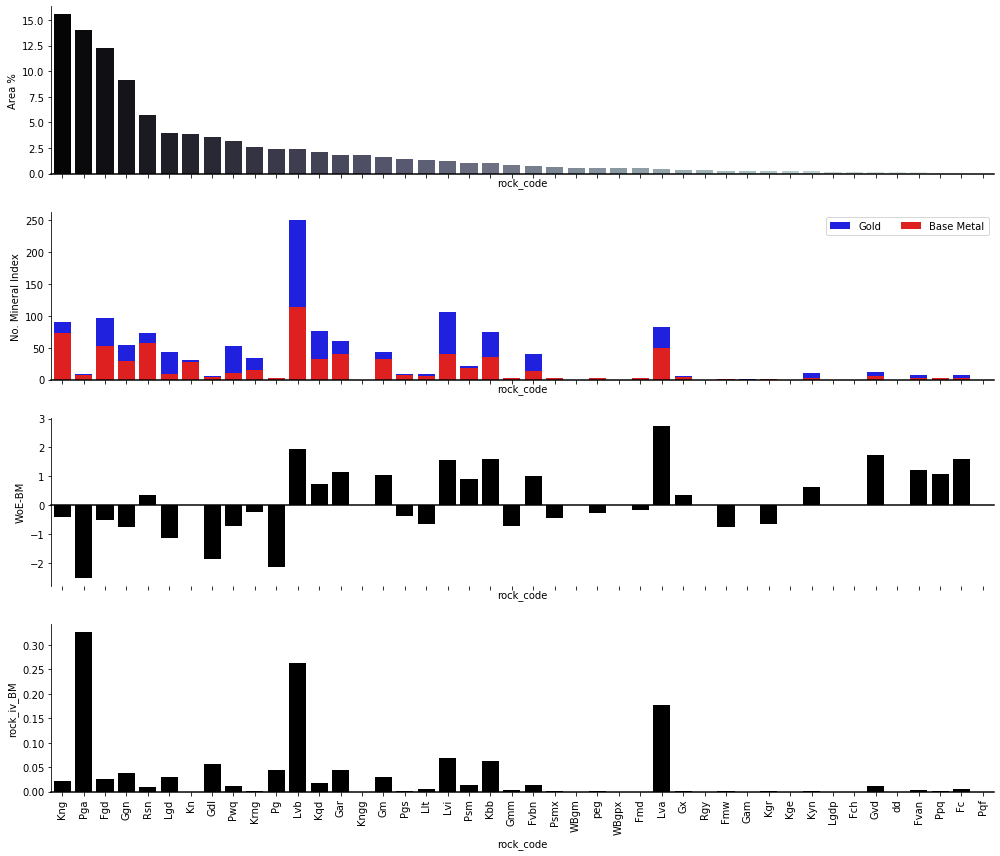

In [74]:
#sorted before plotting
bedrock=bedrock.sort_values(['%area'],ascending=False).reset_index(drop=True)
# plot
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

sns.barplot(x=bedrock['rock_code'], y=bedrock['%area'], palette='bone', ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Area %")

sns.barplot(x=bedrock['rock_code'], y= bedrock['Base Metal']+bedrock['Gold'], color='blue',ax=ax2, label='Gold')
sns.barplot(x=bedrock['rock_code'], y= bedrock['Base Metal'], color='red', ax=ax2, label='Base Metal')
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("No. Mineral Index")
ax2.legend(loc=1, ncol = 2)

sns.barplot(x=bedrock['rock_code'], y=bedrock['rock_woe_BM'], ax=ax3, color='k')
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("WoE-BM")

sns.barplot(x=bedrock['rock_code'], y=bedrock['rock_iv_BM'], ax=ax4, color='k')
ax4.axhline(0, color="k", clip_on=False)

plt.xticks(rotation='vertical')
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)


## metamorphic facies and mineral indices - woe and iv

In [75]:
m_facies[['meta_f_woe_BM', 'meta_f_iv_BM']]= m_facies['meta_f'].apply(woe_iv_encoder, target='Base Metal', col='meta_f')
m_facies[['meta_f_woe_Gold', 'meta_f_iv_Gold']]= m_facies['meta_f'].apply(woe_iv_encoder, target='Gold', col='meta_f')

In [76]:
m_facies.replace(np.inf, 0, inplace=True)
m_facies.replace(-np.inf, 0, inplace=True)

In [77]:
m_facies= m_facies.merge(df.groupby('meta_f', as_index=False)[['Base Metal','Gold']].sum(), on='meta_f')
m_facies['%area']=(m_facies.area/m_facies.area.sum())*100

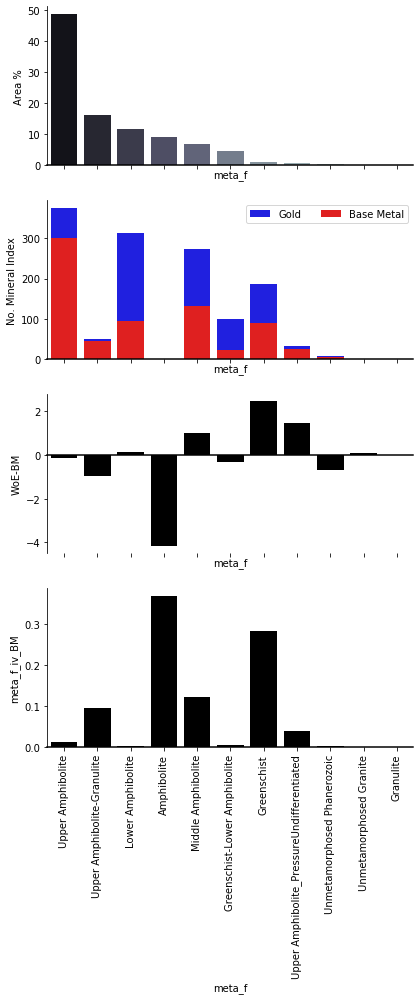

In [78]:
#sorted before plotting
m_facies=m_facies.sort_values(['%area'],ascending=False).reset_index(drop=True)
# plot
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(6, 14), sharex=True)

sns.barplot(x=m_facies['meta_f'], y=m_facies['%area'], palette='bone', ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Area %")

sns.barplot(x=m_facies['meta_f'], y= m_facies['Base Metal']+m_facies['Gold'], color='blue',ax=ax2, label='Gold')
sns.barplot(x=m_facies['meta_f'], y= m_facies['Base Metal'], color='red', ax=ax2, label='Base Metal')
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("No. Mineral Index")
ax2.legend(loc=1, ncol = 2)

sns.barplot(x=m_facies['meta_f'], y=m_facies['meta_f_woe_BM'], ax=ax3, color='k')
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("WoE-BM")

sns.barplot(x=m_facies['meta_f'], y=m_facies['meta_f_iv_BM'], ax=ax4, color='k')
ax4.axhline(0, color="k", clip_on=False)

plt.xticks(rotation='vertical')
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

In [79]:
# adds woe values from bedrock to df
df=pd.merge(df,m_facies[['meta_f','meta_f_woe_BM','meta_f_woe_Gold']],how='left' ,left_on='meta_f', right_on='meta_f')

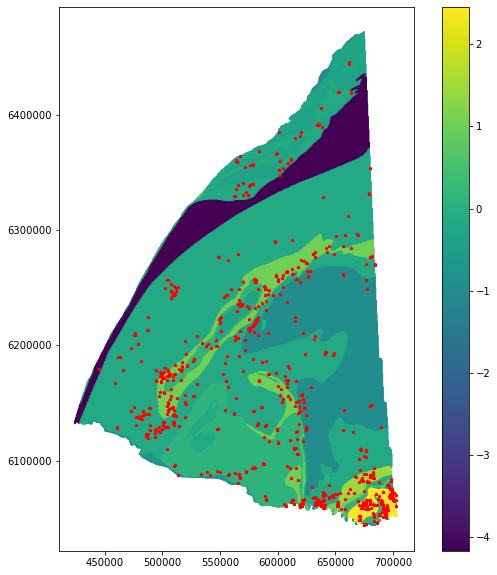

In [80]:
fig, axes= plt.subplots(1,1,figsize=(10,10))
df.loc[df['aoi']].plot(column='meta_f_woe_BM', ax=axes, markersize=0.5, legend=True)
df.loc[df['Base Metal']==1].plot(marker='*', color='r', markersize=8, ax=axes)

## fault buffer zones
* Faults and lineaments were used to create distance-based continious variables. Location of mineral showings in relation to linear structures and possible concentration around them (if exists) can be used to generate new features indicating more important zones around faults and lineaments. To find threshold to create buffers, a range of distance from 1km to 12km with 1km interval was used, and WoE was calculated for cumulative buffer distances. Then, the WoE values were plotted against the buffer distances. Threshold for buffer distance was selected where there was a peak in the plot or change in the pattern. Distances used as threshold are as follow:


* Faults: **2.5 km** and **4.5 km** buffers for Base Metal; **3.5 km** and **5.5 km** buffers for Gold


* At first, arbitrary values (0 to 2) were used to assign to each buffer zones. But, using the average WoE of each buffer zone seemed more reasonable. Having discrete feature can enhance the impact of proximity to the linear structure compared to having a continous variable. Categories with similar WoE have almost same proportion of events and non-events, which means the behavior of both categories is same. So, buffers with similar WoE can be combined together. 

In [81]:
import category_encoders as ce

In [82]:
def lineament_buffer_woe(distance_col, target):
    woe=[]
    buffers=[]
    for i in range (1000,12000,1000):
        woe_encoder = ce.WOEEncoder()
        x_woe= df.loc[df['aoi'],distance_col].apply(lambda x: 'within' if x<i else 'outside')
        y_woe= df.loc[df['aoi'],target]

        woe_fault = woe_encoder.fit_transform(x_woe,y_woe).drop_duplicates()   
        woe_fault_within= float(woe_fault[woe_fault.index.isin(x_woe[x_woe=='within'].index)].values[0])

        woe.append(woe_fault_within)
        buffers.append(i)
    return pd.DataFrame({'buffer':buffers, 'woe':woe})

In [83]:
f_bm=lineament_buffer_woe('dist_to_faults', 'Base Metal')
f_gold=lineament_buffer_woe('dist_to_faults', 'Gold')

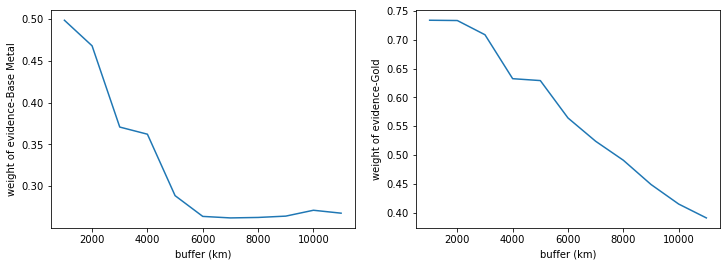

In [84]:
fig, axes= plt.subplots(1,2, figsize=(12,4))
axes[0].plot(f_bm['buffer'], f_bm['woe'])
axes[0].set_xlabel('buffer (km)')
axes[0].set_ylabel('weight of evidence-Base Metal')

axes[1].plot(f_gold['buffer'], f_gold['woe'])
axes[1].set_xlabel('buffer (km)')
axes[1].set_ylabel('weight of evidence-Gold')

plt.show()

In [85]:
df.loc[df['dist_to_faults']<2500, 'fault_buffer_BM']= f_bm.loc[f_bm['buffer']<2500,'woe'].mean() 

df.loc[(df['dist_to_faults']>=2500)&(df['dist_to_faults']<4500), 'fault_buffer_BM']= f_bm.loc[
    (f_bm['buffer']>=2500)& (f_bm['buffer']<4500),'woe'].mean()

df.loc[df['dist_to_faults']>=4500, 'fault_buffer_BM']= f_bm.loc[f_bm['buffer']>=4500,'woe'].mean()                    
                                                 

In [86]:
df.loc[df['dist_to_faults']<3500, 'fault_buffer_Gold']= f_gold.loc[f_gold['buffer']<3500,'woe'].mean() 

df.loc[(df['dist_to_faults']>=3500)&(df['dist_to_faults']<5500), 'fault_buffer_Gold']= f_gold.loc[
    (f_gold['buffer']>=3500)& (f_gold['buffer']<5500),'woe'].mean()

df.loc[df['dist_to_faults']>=5500, 'fault_buffer_Gold']= f_gold.loc[f_gold['buffer']>=5500,'woe'].mean()    

(None, None)

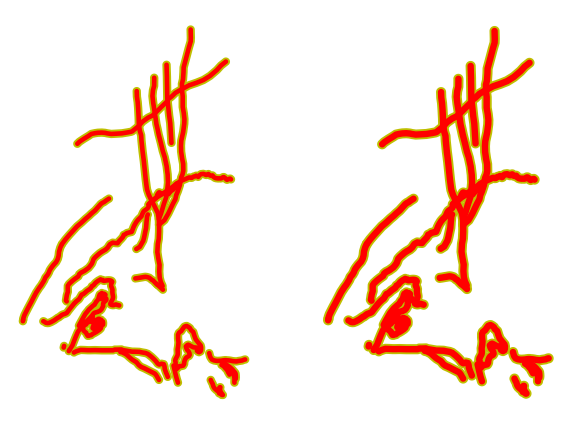

In [87]:
fig, axes= plt.subplots(1,2, figsize=(10,10))
faults.buffer(4500).plot(color='y', ax=axes[0])
faults.buffer(2500).plot(color='r', ax=axes[0])

faults.buffer(5500).plot(color='y', ax=axes[1])
faults.buffer(3500).plot(color='r', ax=axes[1])

axes[0].set_axis_off(), axes[1].set_axis_off()

# data scaling
* After new data were added to df and categorical variables were converted to numerical features, all variables were scaled to have unit variance. It's a critical step, particularly for models that are based on Eucliden distance. 

In [88]:
# rmi was the only skewed variable
df.loc[df['aoi'],'rmi']= df.loc[df['aoi'],'rmi']+abs(df.loc[df['aoi'],'rmi'].min())+1
df.loc[df['aoi'],'rmi']= df.loc[df['aoi'],'rmi'].apply(np.log)

In [89]:
numeric_variables= df.select_dtypes([np.number]).drop(['Base Metal','Gold'], axis=1).columns.to_list()

scaler=StandardScaler()
df.loc[df['aoi'], numeric_variables]= scaler.fit_transform(
        df.loc[df['aoi'], numeric_variables])

# training/testing data generation
* In this step, a subset of features and data that are going to be used for data modeling is created. Two new variables are defined to store features used for Base Metal and Gold. So that no features related to Gold is used for Base Metal and vice versa. There are some features excluded from this list such as PCs and rmi_as becuase they were considered not helpful for modeling. Lake sediment data are removed from this list because they are used to select non-target data. If they are not removed from the data, they add bias to the model significantly.


* There are different approaches for selecting samples for non-target area or barren zones. One way is to select random points from areas where no target is reported. It is not accurate doing this as not having targets in an area might be related to lack of exploration activities in that area. The data can be selected based on one or more features such as being far from lineament and known mineral showings, selected from specific rock units, corresponding to low or high geophysical anomaly, or low or high assay values. 


* Here, the non-target samples were selected based on Lake Sediment Data (Au, Cu, Zn, Pb, Co, Ni). First, values for each element were divided into three group: high(H), medium(M) and low (L) groups. **b_index**  stores indices of points that are not within high zones (all indicator elements should be L or M). Obviously, indices of targets were dropped from b_index to make sure none of the targets is included in the barren df (there were very few). The size of barren_df (created using b_index) was significantly larger than targets, which results in an imbalanced datset. So, a subset of barren_df should be selected to match  (or slightly different from) the size of targets. The samples were randomly selected, but it was assured that they were equally selected from each block; otherwise, any modeling work would be biased to a block with the most samples. 

* When a subset of barren_df was created, it was merged with target data (**df_joined**). It is the main dataset for classification. The dataset was splitted into train and test dataset to be used for modeling. The function returns split dataset ready to use.  

In [90]:
variables_BMetal=['dist_to_faults', 'rmi', 'rmi_as', 'grav', 'meta_f_woe_BM',
       'rock_woe_BM', 'fault_buffer_BM', 'Base Metal', 'nts']

variables_Gold=['dist_to_faults','rmi', 'rmi_as', 'grav', 'meta_f_woe_Gold', 
       'rock_woe_Gold', 'fault_buffer_Gold', 'Gold', 'nts']

In [91]:
def data_selection(target, sample_size):
    indicator_elements= ['au','cu','zn','pb','co','ni'] 
    # qcut is applied to df because it should be for the whole data
    df_qcut= df.loc[df['aoi_wo_lake'], indicator_elements].apply(pd.qcut, q= 3, labels=['L','M','H'])
    
    # conditions to slice df_block where elements are low
    b_index=df_qcut[(df_qcut['au']!='H') & (df_qcut['cu']!='H') & (df_qcut['zn']!='H') & \
    (df_qcut['pb']!='H') & (df_qcut['co']!='H') & (df_qcut['ni']!='H')].index

    if target=='Base Metal':
        variables=variables_BMetal
    if target=='Gold':
        variables=variables_Gold

    barren_df= df[df['aoi_wo_lake']].loc[(b_index), variables]
    barren_df=barren_df[barren_df[target]==0]
    
    barren_df=barren_df.groupby('nts').sample(sample_size)
    target_df= df[df['aoi']].loc[df[target]==1, variables]    
    
    df_joined=pd.concat([barren_df, target_df], axis=0)
    
    X=df_joined.drop([target,'nts'], axis=1)
    y=df_joined[target]
    X_train, X_test, y_train, y_test= train_test_split(X, y,stratify=df_joined[['nts', target]], test_size=0.3)
    return X_train, X_test, y_train, y_test

# modeling
* Classifiers are defined, and trained using the training dataset. Models are evaluated using AUC parameter. Confusion matrix was also very helpful to provide a clear picture for evaluating models. If models require hyper-parameters, they are tuned using grid-search. After a model is evaluated, it is tested using test data. After an acceptable performance was achieved, the model was applied to the whole dataset and the result of prediction was mapped in a binary form (0 or 1) and probability values (higher probability indicates higher potential for targets). To create a binary map, predicted probablity values were averaged, then a threshold value of 0.5 was applied to the data. Support Vector Machine (SVM) and Random Forest (RF) were two classification algorithms used in this work. After the modeling, feature importance was reviewd. Feature importance is a score assigned to input features to a predictive model that indicates the relative importance of each feature when making a prediction. 

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [93]:
train_x_BM, test_x_BM, train_y_BM, test_y_BM= data_selection('Base Metal', 150)

train_x_Gold, test_x_Gold, train_y_Gold, test_y_Gold= data_selection('Gold', 150)

cv_k= StratifiedKFold(n_splits=6)

## svm

In [94]:
svc=SVC(probability=True)
svc_param={'kernel':['linear', 'rbf'], 'C':[c for c in range(1,4, 1)]}

### Base Metal

In [95]:
svc_bm= GridSearchCV(svc, param_grid=svc_param, cv=cv_k)
svc_bm.fit(train_x_BM, train_y_BM)

svc_bm.best_params_

{'C': 1, 'kernel': 'linear'}

In [96]:
print(confusion_matrix(train_y_BM, svc_bm.best_estimator_.predict(train_x_BM)))
print('recall: {:2.2%}'.format(recall_score(test_y_BM, svc_bm.best_estimator_.predict(test_x_BM))))

[[544  86]
 [181 318]]
recall: 65.89%


In [97]:
df.loc[df['aoi'],'svc_bm_prob']=svc_bm.best_estimator_.predict_proba(
        df.loc[df['aoi'],variables_BMetal].drop(['Base Metal','nts'], axis=1))[:,1]

### Gold

In [98]:
svc_gold= GridSearchCV(svc, param_grid=svc_param, cv=cv_k)
svc_gold.fit(train_x_Gold, train_y_Gold)

svc_gold.best_params_

{'C': 3, 'kernel': 'rbf'}

In [99]:
print(confusion_matrix(train_y_Gold, svc_gold.best_estimator_.predict(train_x_Gold)))
print('recall: {:2.2%}'.format(recall_score(train_y_Gold, svc_gold.best_estimator_.predict(train_x_Gold))))

[[579  51]
 [ 55 375]]
recall: 87.21%


In [100]:
df.loc[df['aoi'],'svc_gold_prob']=svc_gold.best_estimator_.predict_proba(
        df.loc[df['aoi'],variables_Gold].drop(['Gold','nts'], axis=1))[:,1]

## random forest

In [101]:
rf=RandomForestClassifier(class_weight={0:1, 1:1})
 
rf_param={'n_estimators':[e for e in range(50,200,50)], 
          'max_depth':[d for d in range(2,6,1)],
          'min_samples_split' : [2, 5],
          'min_samples_leaf' : [2,5]}

### Base Metal

In [102]:
rf_bm = GridSearchCV(rf, param_grid=rf_param, cv=cv_k)
rf_bm.fit(train_x_BM, train_y_BM)

rf_bm.best_params_

{'max_depth': 4,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 50}

In [103]:
print(confusion_matrix(test_y_BM, rf_bm.best_estimator_.predict(test_x_BM)))
print('recall: {:2.2%}'.format(recall_score(test_y_BM, rf_bm.best_estimator_.predict(test_x_BM))))

[[212  58]
 [ 56 158]]
recall: 73.83%


In [104]:
df.loc[df['aoi'],'rf_bm_prob']=rf_bm.best_estimator_.predict_proba(
        df.loc[df['aoi'],variables_BMetal].drop(['Base Metal','nts'], axis=1))[:,1]

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

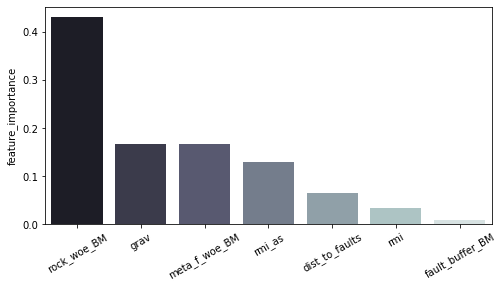

In [105]:
feat_importance_rf_bm= pd.DataFrame(rf_bm.best_estimator_.feature_importances_, 
                                 index=[c for c in variables_BMetal if c not in ('nts','Base Metal')], 
                                 columns=['feature_importance'])
feat_importance_rf_bm=feat_importance_rf_bm.sort_values('feature_importance', ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(feat_importance_rf_bm.index,feat_importance_rf_bm['feature_importance'], palette='bone')
plt.xticks(rotation=30)

### Gold

In [106]:
rf_gold = GridSearchCV(rf, param_grid=rf_param, cv=cv_k)
rf_gold.fit(train_x_Gold, train_y_Gold)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight={0: 1, 1: 1}),
             param_grid={'max_depth': [2, 3, 4, 5], 'min_samples_leaf': [2, 5],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 150]})

In [107]:
rf_gold.best_params_

{'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 50}

In [108]:
print(confusion_matrix(test_y_Gold, rf_gold.best_estimator_.predict(test_x_Gold)))
print('recall: {:2.2%}'.format(recall_score(train_y_Gold, rf_gold.best_estimator_.predict(train_x_Gold))))

[[244  26]
 [ 45 140]]
recall: 86.74%


In [109]:
df.loc[df['aoi'],'rf_gold_prob']=rf_gold.best_estimator_.predict_proba(
        df.loc[df['aoi'],variables_Gold].drop(['Gold','nts'], axis=1))[:,1]

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

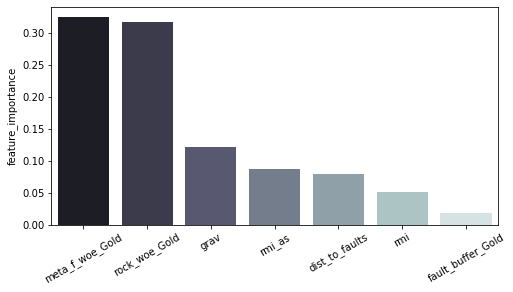

In [110]:
feat_importance_rf_gold= pd.DataFrame(rf_gold.best_estimator_.feature_importances_, 
                                 index=[c for c in variables_Gold if c not in ('nts','Gold')], 
                                 columns=['feature_importance'])
feat_importance_rf_gold=feat_importance_rf_gold.sort_values('feature_importance', ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(feat_importance_rf_gold.index,feat_importance_rf_gold['feature_importance'], palette='bone')
plt.xticks(rotation=30)

## Binary maps and SMDI

In [111]:
df['bm_prob']=(df['svc_bm_prob']+df['rf_bm_prob'])/2 
df['gold_prob']= (df['svc_gold_prob']+df['rf_gold_prob'])/2

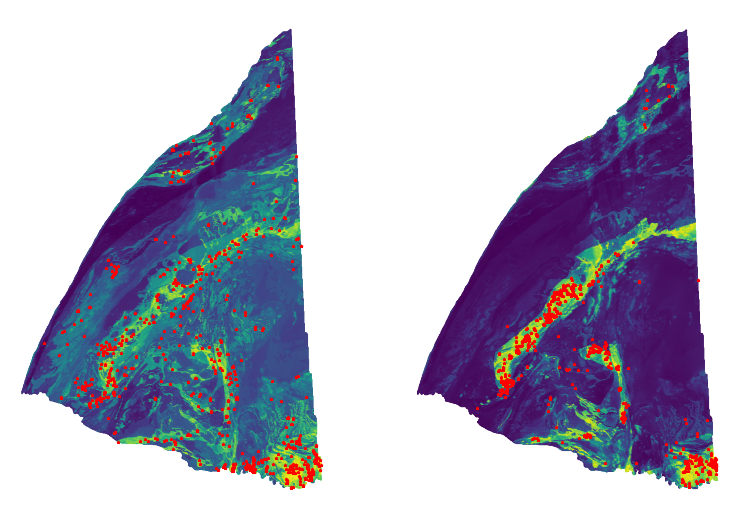

In [122]:
fig, axes= plt.subplots(1,2,figsize=(13,13))

df.loc[df['aoi']].plot(column='bm_prob', ax=axes[0], markersize=0.5)
df.loc[df['Base Metal']==1].plot(marker='*', color='r', markersize=8, ax=axes[0])

df.loc[df['aoi']].plot(column='gold_prob', ax=axes[1], markersize=0.5)
df.loc[df['Gold']==1].plot(marker='*', color='r', markersize=8, ax=axes[1])

axes[0].set_axis_off(); axes[1].set_axis_off()

In [113]:
df['bm_pred']=df['bm_prob'].apply(lambda x: 'Target' if x>0.5 else 'Non-target')
df['gold_pred']=df['gold_prob'].apply(lambda x: 'Target' if x>0.5 else 'Non-target')

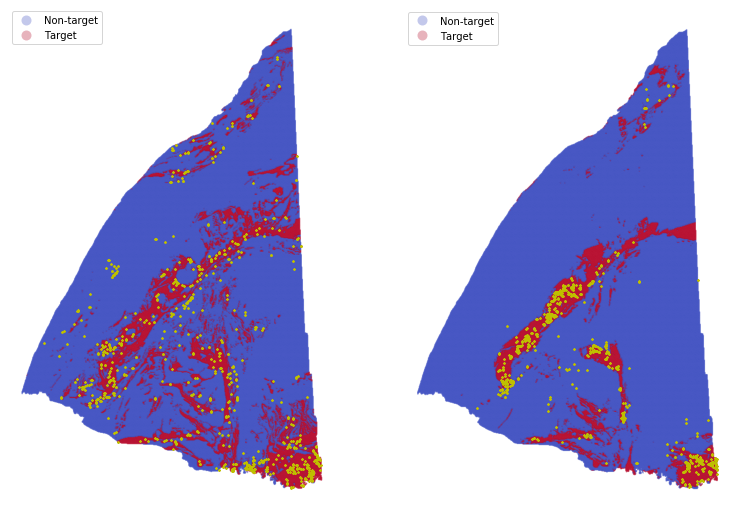

In [123]:
fig, axes= plt.subplots(1,2,figsize=(13,13))

df.loc[df['aoi']].plot(column='bm_pred', ax=axes[0], markersize=0.5, cmap='coolwarm', alpha=0.3, legend=True)
df.loc[df['Base Metal']==1].plot(marker='*', color='y', markersize=4, ax=axes[0])

df.loc[df['aoi']].plot(column='gold_pred', ax=axes[1], markersize=0.5, cmap='coolwarm', alpha=0.3, legend=True)
df.loc[df['Gold']==1].plot(marker='*', color='y', markersize=4, ax=axes[1])

axes[0].set_axis_off(); axes[1].set_axis_off()

In [115]:
print('% of aoi identified as target zone {:2.2%}'.format((df['bm_pred']=='Target').sum()/len(df.loc[df['aoi']])))
print('% of aoi identified as target zone {:2.2%}'.format((df['gold_pred']=='Target').sum()/len(df.loc[df['aoi']])))

% of aoi identified as target zone 19.63%
% of aoi identified as target zone 11.66%


**Distribution of mineral indices being predicted as target and non-target:**

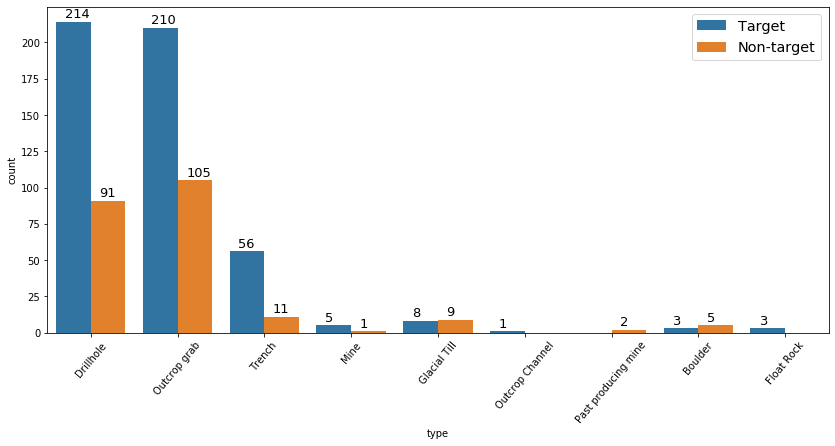

In [116]:
plt.figure(figsize=(14,6))
ax = sns.countplot(x='type', hue='bm_pred',  hue_order=['Target','Non-target'], data=df[df['Base Metal']==1])
plt.xticks(rotation=50)
plt.legend(fontsize='x-large')
plt.legend(fontsize='x-large', loc='upper right')
for p in ax.patches:
        count = '{:.0f}'.format(p.get_height())
        x = p.get_x()+0.1 
        y = p.get_height()+3
        ax.annotate(count, (x, y),fontsize =13)


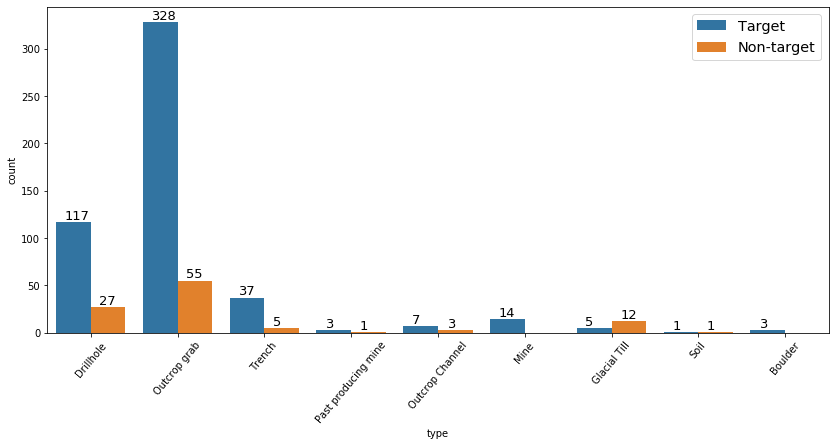

In [117]:
plt.figure(figsize=(14,6))
ax = sns.countplot(x='type', hue='gold_pred', hue_order=['Target','Non-target'], data=df[df['Gold']==1])
plt.xticks(rotation=50)
plt.legend(fontsize='x-large', loc='upper right')

for p in ax.patches:
        count = '{:.0f}'.format(p.get_height())
        x = p.get_x()+0.1 
        y = p.get_height()+3
        ax.annotate(count, (x, y),fontsize =13)

# comparison to the existing resource map
The results were compared to the existing resource map which was created subjectively based on the distribution of mineral indices. 

In [118]:
sgs_resource=gpd.read_file('resource_assessment_SGS.shp')

In [119]:
# removes null entries from the data
sgs_resource= sgs_resource[(sgs_resource['DEP_TYPE1'].notnull()) & (sgs_resource['DEP_TYPE1']!='None')]
sgs_resource=gpd.overlay(sgs_resource, aoi)
sgs_resource['RATING1']=sgs_resource['RATING1'].astype(int)

In [120]:
# creates lists for base metals deposit types and gold deposit types
deposit_list= list(sgs_resource['DEP_TYPE1'].unique())

bm_list= [d for d in deposit_list if ('Cu' in d)| ('massive' in d.lower())]
gold_list=[d for d in deposit_list if ('gold' in d.lower())]

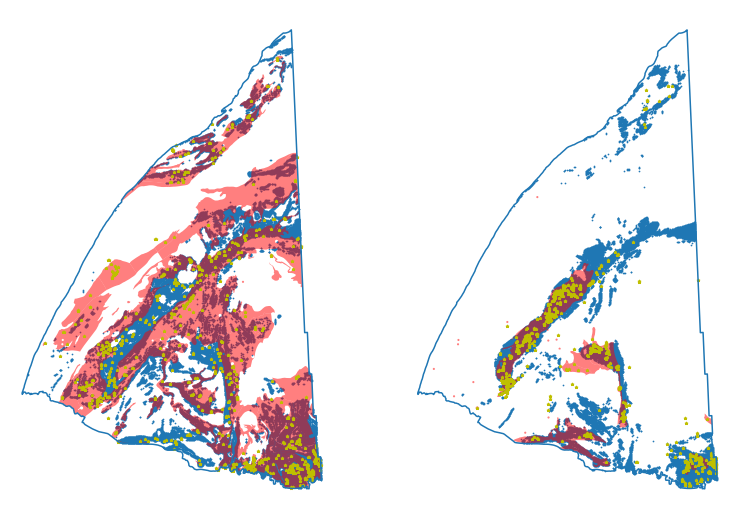

In [124]:
fig, axes= plt.subplots(1,2,figsize=(13,13))
df[df['bm_pred']=='Target'].plot(ax=axes[0], markersize=0.5)
sgs_resource[(sgs_resource['DEP_TYPE1'].isin(bm_list))& (sgs_resource['RATING1']>2)].plot(color='r', alpha=0.5, ax=axes[0])
aoi.boundary.plot(ax=axes[0])
df.loc[df['Base Metal']==1].plot(marker='*', color='y', markersize=8, ax=axes[0])

df[df['gold_pred']=='Target'].plot(ax=axes[1], markersize=0.5)
sgs_resource[(sgs_resource['DEP_TYPE1'].isin(gold_list))& (sgs_resource['RATING1']>0)].plot(color='r', alpha=0.5, ax=axes[1])
aoi.boundary.plot(ax=axes[1])
df.loc[df['Gold']==1].plot(marker='*', color='y', markersize=8, ax=axes[1])

axes[0].set_axis_off(); axes[1].set_axis_off()